# Reinforcement Learning with PPO algorithm ###

In [1]:
import at
import pickle
import matplotlib.pyplot as plt
import numpy as np
import utils_ext as utils
import torch
import torchrl
import os
from tensordict import TensorDict, TensorDictBase
from tensordict.nn import TensorDictModule
from collections import defaultdict
from torchrl.envs.common import EnvBase


from torchrl.data import Bounded, Composite, Unbounded

from typing import Optional
from tqdm import tqdm

torch.autograd.set_detect_anomaly(True, True)

## Set up simulation environment

Read lattices into memory

In [2]:
path_str = "./lattices/seed{x:03d}_pyAT_postRFcorrection"
dir_path = "./lattices/"

In [3]:
lattice_files = [path_str.format(x = i + 1) for i in range(100)]
rings = []
for lattice_file in lattice_files:
    with open(lattice_file,'rb') as fid:
        rings.append(pickle.load(fid))


dataset_size = len(next(os.walk(dir_path))[2])
print(dataset_size)

100


In [5]:
import time
from multiprocessing import Process, Pipe

class LatticeEnv(EnvBase):
    """Parallelized lattice simulation training environment.

    Rings are simulated in parallel, with each given its own worker process.
    TODO: add support for mapping single worker processes to multiple rings
          to support bigger batches without the overhead of excessive context
          switching.
    """
    batch_locked = True 
    def __init__(self, path_str, ds_size, batch_size, device="cpu", 
                 nan_cost=1, done_delta=-3e-3, norm_const=1e-5, seed=42): #3e-6
        super().__init__(device=device, batch_size=[batch_size])
  
        self.nan_cost = nan_cost
        self.done_delta = done_delta
        self.norm_const = norm_const

        self._set_seed(seed)

        self.conns = [Pipe() for i in range(batch_size)]
        self.conns, worker_conns = zip(*self.conns)
        # the worker process function was put into utils due to a bug with
        # jupyter and multiprocessing
        self.workers = [Process(target=utils.WorkerProcess, args=(path_str, [idx, self.seed], ds_size,
                                                                   conn, self.nan_cost, self.done_delta)) 
                        for idx, conn in enumerate(worker_conns)]

        print("initializing worker processes")
        for worker in tqdm(self.workers):
            worker.start()

        print("testing connections")
        self.test_conns()

        self.bpm_len = utils.getBPMreading(rings[0])[0].shape[0]
        self.cm_len = utils.getCorrectorStrengths(rings[0], "x").size + utils.getCorrectorStrengths(rings[0], "y").size

        self._make_spec()
        

    def test_conns(self):
        for worker in self.workers:
            if not worker.is_alive():
                print("dead worker")
                break

        for conn in self.conns:
            conn.send(("ping", None))
            if conn.recv() != "received":
                print("faulty pipe detected")
                return
        print("all pipes working")


    def _step(self, tensordict):

        assert torch.all(~torch.isnan(tensordict["action"]))
        
        step_start = time.time()

        # should probably obtain this scaling constant in a better way...
        actions = (tensordict["action"] * self.norm_const)
        actions = actions.numpy(force=True)
                
        # get batched costs for current corrector magnet strengths
        corrector_start = time.time()
        for conn, action in zip(self.conns, actions):
            conn.send(("step", action.copy()))
        
        costs = []
        new_bpms = []
        dones = []
        for conn in self.conns:
            cost, new_bpm, done = conn.recv()
            costs.append(cost)
            new_bpms.append(new_bpm)
            dones.append(done)
        
        costs = torch.tensor(np.stack(costs), dtype=torch.float32, device=self.device)
        new_bpms = torch.tensor(np.stack(new_bpms), dtype=torch.float32, device=self.device)

        reward = -costs.view(self.batch_size[0], 1)
        done = torch.tensor(np.stack(dones), dtype=torch.bool, device=self.device)
        done = done.view(self.batch_size[0], 1)
        out = TensorDict(
            {
                "bpm": new_bpms,
                "reward": reward,
                "done": done,
            },
            tensordict.shape,
            device=self.device
        )
        return out


    def _reset(self, tensordict):

        command = "reset"
        # a tensordict arg means we are doing a partial reset
        if tensordict is not None:
            #print("partial reset")
            command = "maybe_reset"

        reset_start = time.time()

        for conn in self.conns:
            conn.send((command, None))
    
        new_bpms = []
        for conn in self.conns:
            _, new_bpm, _ = conn.recv()
            new_bpms.append(new_bpm)
        
        new_bpms = torch.tensor(np.stack(new_bpms), dtype=torch.float32, device=self.device)

        if tensordict is not None:
            tensordict["bpm"] = new_bpms
            out = tensordict
        else: 
            out = TensorDict(
                {
                    "bpm": new_bpms,
                },
                batch_size=self.batch_size,
                device=self.device
            )

        #print(f"one reset took {time.time() - reset_start} seconds")
        return out


    def _make_spec(self):

        self.observation_spec = Composite(
            bpm=Unbounded(shape=(self.batch_size[0], self.bpm_len, 2), 
                          dtype=torch.float32, 
                          device=self.device), 
            shape=self.batch_size,
        )

        # as this environment is stateful, could probably get rid of this
        self.state_spec = self.observation_spec.clone()

        # make this boundary an arg on initialization?
        self.action_spec = Bounded(
            low=-2.5e-4 / self.norm_const,
            high=2.5e-4 / self.norm_const,
            shape=(self.batch_size[0], self.cm_len),
            dtype=torch.float32,
            device=self.device
        )

        self.reward_spec = Unbounded(shape=(self.batch_size[0], 1), device=self.device)


    def _set_seed(self, seed: int=42):
        self.seed = seed
    


Create and check base environment

In [6]:
from torchrl.envs.utils import check_env_specs

env_batch_size = 64
base_env = LatticeEnv(path_str, 1, env_batch_size, device="cuda")
check_env_specs(base_env)

initializing worker processes


100%|██████████| 64/64 [00:00<00:00, 155.13it/s]


testing connections
all pipes working
getBPMreading: 
          checking closed took 0.22449350357055664 secs
          getting BPM indices took 0.0006811618804931641 secs
          finding orbit took 0.0 secs
          finding offset took 0.002591371536254883 secs
          getting noise took 0.002552509307861328 secs


2025-01-25 02:28:01,905 [torchrl][INFO] check_env_specs succeeded!


Add necessary transforms for normalization, etc.

In [7]:
from torchrl.envs import Compose, ObservationNorm, StepCounter, TransformedEnv

env = TransformedEnv(
    base_env,
    Compose(
        # normalize observations
        ObservationNorm(in_keys=['bpm']),
        StepCounter(),
    ),
)

env.transform[0].init_stats(num_iter=2, reduce_dim=(0, 1, 2, 3), cat_dim=0)

check_env_specs(env)

2025-01-25 02:28:06,453 [torchrl][INFO] check_env_specs succeeded!


In [8]:
print("normalization constant shape:", env.transform[0].loc.shape)
print(env.transform[0].loc, env.transform[0].scale)

normalization constant shape: torch.Size([])
tensor(-0.1390, device='cuda:0') tensor(38589.9766, device='cuda:0')


In [9]:
print("observation_spec:", env.observation_spec)
print("reward_spec:", env.reward_spec)
print("input_spec:", env.input_spec)
print("action_spec:", env.action_spec)

observation_spec: Composite(
    bpm: UnboundedContinuous(
        shape=torch.Size([64, 360, 2]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([64, 360, 2]), device=cuda:0, dtype=torch.float32, contiguous=True),
            high=Tensor(shape=torch.Size([64, 360, 2]), device=cuda:0, dtype=torch.float32, contiguous=True)),
        device=cuda:0,
        dtype=torch.float32,
        domain=continuous),
    step_count: BoundedDiscrete(
        shape=torch.Size([64, 1]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([64, 1]), device=cuda:0, dtype=torch.int64, contiguous=True),
            high=Tensor(shape=torch.Size([64, 1]), device=cuda:0, dtype=torch.int64, contiguous=True)),
        device=cuda:0,
        dtype=torch.int64,
        domain=discrete),
    device=cuda:0,
    shape=torch.Size([64]))
reward_spec: UnboundedContinuous(
    shape=torch.Size([64, 1]),
    space=ContinuousBox(
        low=Tensor(shape=torch.Size([64, 1]), device=cud

Perform test rollout with random policy

In [10]:
rollout = env.rollout(2)
print("rollout of two steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of two steps: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([64, 1, 792]), device=cuda:0, dtype=torch.float32, is_shared=True),
        bpm: Tensor(shape=torch.Size([64, 1, 360, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([64, 1, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        next: TensorDict(
            fields={
                bpm: Tensor(shape=torch.Size([64, 1, 360, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                done: Tensor(shape=torch.Size([64, 1, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
                reward: Tensor(shape=torch.Size([64, 1, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                step_count: Tensor(shape=torch.Size([64, 1, 1]), device=cuda:0, dtype=torch.int64, is_shared=True),
                terminated: Tensor(shape=torch.Size([64, 1, 1]), device=cuda:0, dtype=torch.bool, is_shared=True)},
            batch_

## Define actor and critic models

Create actor network and wrap in policy module

In [11]:
from torch import nn
from tensordict.nn import NormalParamExtractor

cm_len = env.action_spec.shape[1]
bpm_shape = env.observation_spec["bpm"].shape[1:]

device = "cuda"
actor_net = nn.Sequential(
    nn.Flatten(start_dim=-2),
    #nn.LazyLinear(bpm_shape[0] * bpm_shape[1], device=device),
    #nn.ReLU(),
    #nn.LazyLinear(bpm_shape[0] * bpm_shape[1], device=device),
    #nn.ReLU(),
    nn.LazyLinear(cm_len * 2, device=device),
    NormalParamExtractor(scale_mapping="softplus", scale_lb=1e-1),
)
"biased_softplus_1.0"
policy_module = TensorDictModule(
    actor_net, in_keys=["bpm"], out_keys=["loc", "scale"]
)

Create probabilistic actor using policy module

In [12]:
from torchrl.modules import ProbabilisticActor, TanhNormal, IndependentNormal, ValueOperator

policy_module = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=["loc", "scale"],
    distribution_class=IndependentNormal,
    distribution_kwargs={
    },
    return_log_prob=True,
    # we'll need the log-prob for the numerator of the importance weights
)

Create value network and critic module

In [13]:
bpm_len = bpm_shape[0] * bpm_shape[1]
value_net = nn.Sequential(
    nn.Flatten(start_dim=-2),
    #nn.Linear(bpm_len, bpm_len, device=device),
    #nn.ReLU(),
    #nn.Linear(bpm_len, bpm_len, device=device),
    #nn.ReLU(),
    nn.Linear(bpm_len, 1, device=device),
)

value_module = ValueOperator(
    module=value_net,
    in_keys=["bpm"],
)

In [14]:
print("Running policy:", policy_module(env.reset()))
print("Running value:", value_module(env.reset()))

Running policy: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([64, 792]), device=cuda:0, dtype=torch.float32, is_shared=True),
        bpm: Tensor(shape=torch.Size([64, 360, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([64, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        loc: Tensor(shape=torch.Size([64, 792]), device=cuda:0, dtype=torch.float32, is_shared=True),
        sample_log_prob: Tensor(shape=torch.Size([64]), device=cuda:0, dtype=torch.float32, is_shared=True),
        scale: Tensor(shape=torch.Size([64, 792]), device=cuda:0, dtype=torch.float32, is_shared=True),
        step_count: Tensor(shape=torch.Size([64, 1]), device=cuda:0, dtype=torch.int64, is_shared=True),
        terminated: Tensor(shape=torch.Size([64, 1]), device=cuda:0, dtype=torch.bool, is_shared=True)},
    batch_size=torch.Size([64]),
    device=cuda:0,
    is_shared=True)
Running value: TensorDict(
    fields={
        bpm: T

## Set up PPO algorithm and replay buffer

Create data collector object

In [15]:
from torchrl.collectors import SyncDataCollector

frames_per_batch = env_batch_size * 12

outer_epochs = 128 * 6
total_frames = frames_per_batch * outer_epochs

collector = SyncDataCollector(
    env,
    policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
    reset_at_each_iter=True
)

We are using the replay buffer technique for enhanced training stability

In [16]:
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage

replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(max_size=frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

Define hyperparameters, create advantage/loss modules and optimizer

In [17]:
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE

sub_batch_size = frames_per_batch  # size of the sub-samples gathered from the current data in the inner loop
num_epochs = 10  # epochs per batch of data collected from interacting w/ env
clip_epsilon = (
    0.2  # clip value for PPO loss
)
gamma = 0.7
lmbda = 0.95
entropy_eps = 1e-8#3e-4
lr =3e-5# 1e-4#1e-8

advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True
)

loss_module = ClipPPOLoss(
    actor_network=policy_module,
    critic_network=value_module,
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    # these keys match by default but we set this for completeness
    critic_coef=1.0,
    loss_critic_type="smooth_l1",
)

optim = torch.optim.Adam(loss_module.parameters(), lr)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, 
#                                                       total_frames // frames_per_batch, 
#                                                       0.0)

## Training and diagnostics

In [18]:
from tqdm import tqdm
from torchrl.envs.utils import check_env_specs, ExplorationType, set_exploration_type


logs = defaultdict(list)
pbar = tqdm(total=total_frames)
eval_str = ""

eval_period = 1

max_grad_norm = 1.0


# We iterate over the collector until it reaches the total number of frames it was
# made to collect, i.e., total_frames
for i, tensordict_data in enumerate(collector):
    # For each batch of data collected, we perform num_epochs rounds of optimization
    for ep in range(num_epochs):
        # Critic network is updated in the inner loop, so need to compute
        # advantage signal too
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)

        # Instead of using the data directly, we add it to the replay buffer
        # and sample it from there
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )
            #for name, loss_val in loss_vals.items():
            #   print(f"{name}: {loss_val}")

            # perform backprop and optimize
            loss_value.backward()
            # clipping isn't necessary here but probably good anyways
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()
            
    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel())
    cum_reward_str = f"mean reward: {logs['reward'][-1]:4.4e} (init: {logs['reward'][0]:4.4e})"
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"max steps: {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    #lr_str = f"lr policy: {logs['lr'][-1]:4.4f}"

    if i % eval_period == 0:
        # By setting the policy module to forgo exploration (take the mean of
        # the output distribution), we can accurately evaluate model performance
        with set_exploration_type(ExplorationType.MEAN), torch.no_grad():
            eval_rollout = env.rollout(3, policy_module)

            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(eval_rollout["next", "reward"].sum().item())
            logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval reward: {logs['eval reward'][-1]:4.4e} "
                f"(init: {logs['eval reward'][0]:4.4e})"
                #f"eval max steps: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description("  ".join([eval_str, cum_reward_str]))

    # maybe use lr scheduler?
    #scheduler.step()

eval reward: -2.8857e-05 (init: -3.3996e-05)  mean reward: -2.9064e-05 (init: -4.4664e-05): 100%|██████████| 589824/589824 [6:15:52<00:00, 26.40it/s]  

eval reward: -2.8857e-05 (init: -3.3996e-05)  mean reward: -2.9064e-05 (init: -4.4664e-05): 100%|██████████| 589824/589824 [6:16:08<00:00, 26.40it/s]

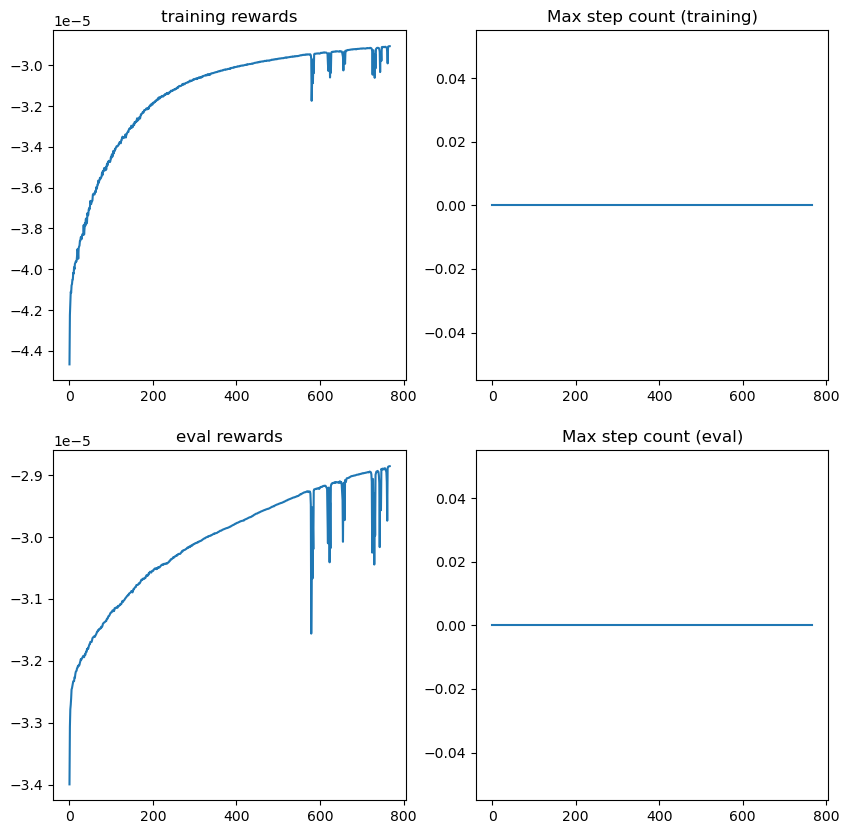

In [19]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max step count (training)")
plt.subplot(2, 2, 3)
plt.plot(logs["eval reward"])
plt.title("eval rewards")
plt.subplot(2, 2, 4)
plt.plot(logs["eval step_count"])
plt.title("Max step count (eval)")
plt.show()

In [21]:
pickle.dump(policy_module, open("policy.p", mode="wb"))

In [42]:
with set_exploration_type(ExplorationType.MEAN), torch.no_grad():
    eval_rollout = env.rollout(1, policy_module)
    print(eval_rollout)

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([64, 1, 792]), device=cuda:0, dtype=torch.float32, is_shared=True),
        bpm: Tensor(shape=torch.Size([64, 1, 360, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([64, 1, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        loc: Tensor(shape=torch.Size([64, 1, 792]), device=cuda:0, dtype=torch.float32, is_shared=True),
        next: TensorDict(
            fields={
                bpm: Tensor(shape=torch.Size([64, 1, 360, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                done: Tensor(shape=torch.Size([64, 1, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
                reward: Tensor(shape=torch.Size([64, 1, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                step_count: Tensor(shape=torch.Size([64, 1, 1]), device=cuda:0, dtype=torch.int64, is_shared=True),
                terminated: Tensor(shape=torch.Size

In [139]:
ring = pickle.load(open(f"./lattices/seed001_pyAT_postRFcorrection", mode="rb"))

getBPMreading: 
          checking closed took 0.22921204566955566 secs
          getting BPM indices took 0.0 secs
          finding orbit took 0.0 secs
          finding offset took 0.002061605453491211 secs
          getting noise took 0.0025377273559570312 secs
[<Axes: ylabel='x [$\\mu$m]'>, <Axes: xlabel='s [m]', ylabel='y [$\\mu$m]'>]
getBPMreading: 
          checking closed took 0.2278599739074707 secs
          getting BPM indices took 0.0010383129119873047 secs
          finding orbit took 0.0 secs
          finding offset took 0.003576993942260742 secs
          getting noise took 0.0030698776245117188 secs
Pre-correction RMS [x, y]: [3.94096821e-05 2.68106909e-05]
Post-correction RMS [x, y]: [3.60478102e-05 2.16658020e-05]
RMS delta [x, y]: [3.36187190e-06 5.14488887e-06]


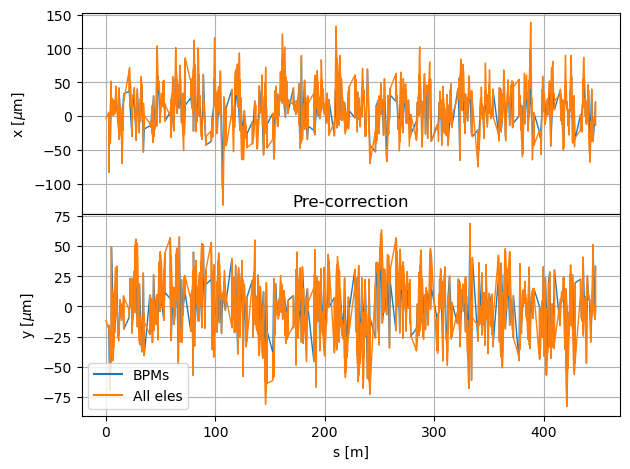

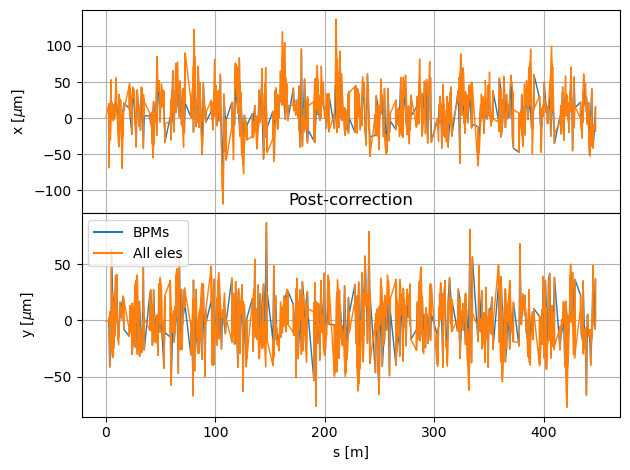

In [140]:
from utils_ext import getBPMreading
import matplotlib.pyplot as plt

actions = (eval_rollout["action"][0] * 1e-5)
actions = actions.numpy(force=True)
hcm = utils.getCorrectorStrengths(ring, 'x')
vcm = utils.getCorrectorStrengths(ring, 'y') 
hcm_sep = len(hcm)
cm = np.append(hcm, vcm)


pre_offsets = getBPMreading(ring, makePlot=1)[1]
fig = plt.gcf()
print(fig.axes)
for axis in fig.axes:
    for line in axis.lines:
        line.set_linewidth(1)
    #line.set_data([[],[]])
plt.title("Pre-correction")

cm += actions[0]
hcm = cm[:hcm_sep]
vcm = cm[hcm_sep:]
ring = utils.setCorrectorStrengths(ring, 'x', hcm, True)
ring = utils.setCorrectorStrengths(ring, 'y', vcm, True)

post_offsets = getBPMreading(ring, makePlot=1)[1]
fig = plt.gcf()
for axis in fig.axes:
    for line in axis.lines:
        line.set_linewidth(1)
    #line.set_data([[],[]])
plt.title("Post-correction")

print(f"Pre-correction RMS [x, y]: {utils.rms(pre_offsets)}")
print(f"Post-correction RMS [x, y]: {utils.rms(post_offsets)}")
print(f"RMS delta [x, y]: {utils.rms(pre_offsets) - utils.rms(post_offsets)}")

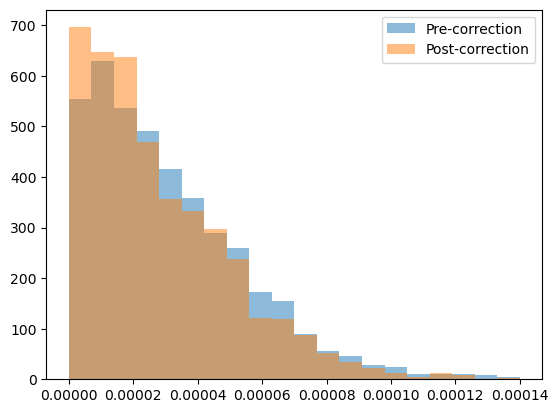

(array([982., 963., 845., 541., 386., 262.,  93.,  34.,  28.,   9.,   5.,
          4.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([0.00e+00, 7.00e-06, 1.40e-05, 2.10e-05, 2.80e-05, 3.50e-05,
        4.20e-05, 4.90e-05, 5.60e-05, 6.30e-05, 7.00e-05, 7.70e-05,
        8.40e-05, 9.10e-05, 9.80e-05, 1.05e-04, 1.12e-04, 1.19e-04,
        1.26e-04, 1.33e-04, 1.40e-04]),
 <BarContainer object of 20 artists>)

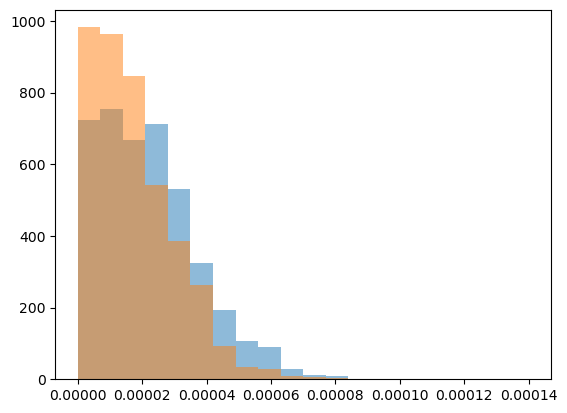

In [114]:
arg_dict = {"bins": 20, "alpha": 0.5, "range": [0, 0.00014]}
plt.hist(np.abs(pre_offsets[..., 0]), **arg_dict)
plt.hist(np.abs(post_offsets[..., 0]), **arg_dict)
plt.legend(["Pre-correction", "Post-correction"])
plt.show()
plt.hist(np.abs(pre_offsets[..., 1]), **arg_dict)
plt.hist(np.abs(post_offsets[..., 1]), **arg_dict)

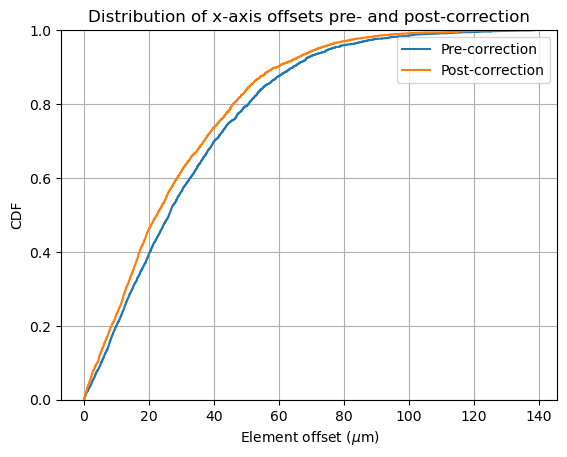

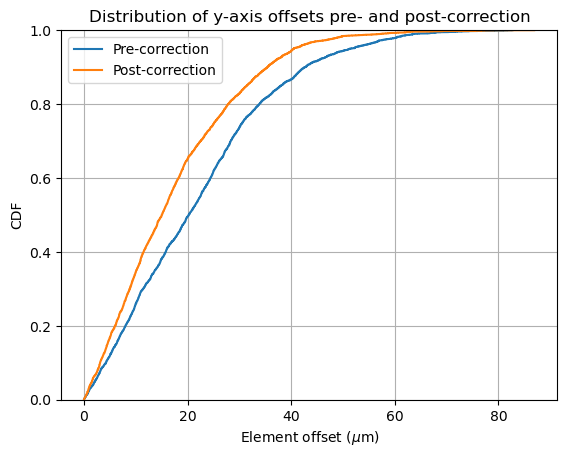

In [142]:
var_list = [('x', 0), ('y', 1)]
for axis, idx in var_list:
    plt.ecdf(np.abs(pre_offsets[..., idx] * 1e6),)
    plt.ecdf(np.abs(post_offsets[..., idx] * 1e6),)
    plt.grid()
    plt.xlabel(r"Element offset ($\mu$m)")
    plt.ylabel("CDF")
    plt.legend(["Pre-correction", "Post-correction"])
    plt.title(f"Distribution of {axis}-axis offsets pre- and post-correction")
    plt.show()